In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing predicted test data csv's

In [94]:
cnn_50=pd.read_csv('/content/drive/My Drive/fnc-1/cnn_50.csv')
cnn_100=pd.read_csv('/content/drive/My Drive/fnc-1/cnn_100.csv')
cnn_150=pd.read_csv('/content/drive/My Drive/fnc-1/cnn_150.csv')

lstm_50=pd.read_csv('/content/drive/My Drive/fnc-1/lstm_50.csv')
lstm_100=pd.read_csv('/content/drive/My Drive/fnc-1/lstm_100.csv')
lstm_150=pd.read_csv('/content/drive/My Drive/fnc-1/lstm_150.csv')

bi_lstm_50=pd.read_csv('/content/drive/My Drive/fnc-1/bi_lstm_50.csv')
bi_lstm_100=pd.read_csv('/content/drive/My Drive/fnc-1/bi_lstm_100.csv')
bi_lstm_150=pd.read_csv('/content/drive/My Drive/fnc-1/bi_lstm_150.csv')

# w2v embeddings

w2v_cnn_50=pd.read_csv('/content/drive/My Drive/fnc-1/w2v_cnn_50.csv')
w2v_lstm_50=pd.read_csv('/content/drive/My Drive/fnc-1/w2v_lstm_50.csv')
w2v_bi_lstm_50=pd.read_csv('/content/drive/My Drive/fnc-1/w2v_bi_lstm_50.csv')

gradient_boosting=pd.read_csv('/content/drive/My Drive/fnc-1/gradientboost.csv')
logistic_regression=pd.read_csv('/content/drive/My Drive/fnc-1/logistic_regression.csv')
random_forest=pd.read_csv('/content/drive/My Drive/fnc-1/Random_Forest.csv')
xgboost=pd.read_csv('/content/drive/My Drive/fnc-1/XGBoost.csv')

bert_base=pd.read_csv('/content/drive/My Drive/fnc-1/bert_base.csv')

gb_undersample=pd.read_csv('/content/drive/My Drive/fnc-1/gradient_boosting_undesample.csv')

### Importing Real labels

In [ ]:
real_bodies=pd.read_csv('/content/drive/My Drive/fnc-1/competition_test_bodies.csv')
real_stances=pd.read_csv('/content/drive/My Drive/fnc-1/competition_test_stances.csv')

# Importing train stances
real_train_stances=pd.read_csv('/content/drive/My Drive/fnc-1/train_stances.csv')

## Exploratory analysis

In [ ]:
real_stances.head(3)

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated


In [ ]:
real_stances['Stance'].unique()

array(['unrelated', 'agree', 'discuss', 'disagree'], dtype=object)

### Test data distribution

In [ ]:
import collections
test_data_dist=collections.Counter(real_stances['Stance'])
print("Test Data Distribution: ",collections.Counter(real_stances['Stance']))

Test Data Distribution:  Counter({'unrelated': 18349, 'discuss': 4464, 'agree': 1903, 'disagree': 697})


## Train Data distribution

In [ ]:
real_train_stances.head(3)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated


In [ ]:
real_train_stances.shape

(49972, 3)

In [ ]:
train_data_dist=collections.Counter(real_train_stances['Stance'])
print("Train Data Distribution: ",collections.Counter(real_train_stances['Stance']))

Train Data Distribution:  Counter({'unrelated': 36545, 'discuss': 8909, 'agree': 3678, 'disagree': 840})


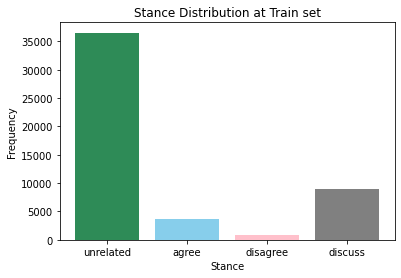

In [ ]:
plt.bar(train_data_dist.keys(),train_data_dist.values(),color=[
                     'seagreen', 'skyblue','pink','gray'])
plt.xlabel("Stance")
plt.ylabel('Frequency')
plt.title('Stance Distribution at Train set')
plt.show()

- Total stances: 49972
  - unrelated: 73.1%
  - agree: 7.3%
  - disagree:1.6%
  - discuss:17.8%

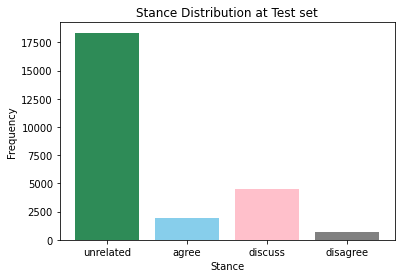

In [ ]:
plt.bar(test_data_dist.keys(),test_data_dist.values(),color=[
                     'seagreen', 'skyblue','pink','gray'])
plt.xlabel("Stance")
plt.ylabel('Frequency')
plt.title('Stance Distribution at Test set')
plt.show()

## Metrics

In [ ]:
#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


In [ ]:

def calculate_f1_scores(y_true, y_predicted):
    
    f1_macro = f1_score(y_true, y_predicted, average='macro')
    f1_classwise = f1_score(y_true, y_predicted, average=None, labels=["agree", "disagree", "discuss", "unrelated"])

    resultstring = "F1 macro: {:.3f}".format(f1_macro * 100) + "% \n"
    resultstring += "F1 agree: {:.3f}".format(f1_classwise[0] * 100) + "% \n"
    resultstring += "F1 disagree: {:.3f}".format(f1_classwise[1] * 100) + "% \n"
    resultstring += "F1 discuss: {:.3f}".format(f1_classwise[2] * 100) + "% \n"
    resultstring += "F1 unrelated: {:.3f}".format(f1_classwise[3] * 100) + "% \n"
    return resultstring

In [ ]:
def class_repo(labels_test,preds_test):
    eval_report = classification_report(labels_test, preds_test)
    print('Test report', eval_report)

## Evaluating CNN 50

In [ ]:
report_score(real_stances['Stance'],cnn_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    65     |    449    |    397    |    992    |
-------------------------------------------------------------
| disagree  |    30     |    132    |    101    |    434    |
-------------------------------------------------------------
|  discuss  |    153    |    551    |   1505    |   2255    |
-------------------------------------------------------------
| unrelated |    310    |   1323    |   1751    |   14965   |
-------------------------------------------------------------
Score: 5863.5 out of 11651.25	(50.32507241712263%)


50.32507241712263

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],cnn_50['Stance']))

F1 macro: 32.797% 
F1 agree: 5.282% 
F1 disagree: 8.376% 
F1 discuss: 36.627% 
F1 unrelated: 80.903% 



In [ ]:
print(class_repo(real_stances['Stance'],cnn_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.12      0.03      0.05      1903
    disagree       0.05      0.19      0.08       697
     discuss       0.40      0.34      0.37      4464
   unrelated       0.80      0.82      0.81     18349

    accuracy                           0.66     25413
   macro avg       0.34      0.34      0.33     25413
weighted avg       0.66      0.66      0.65     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],cnn_50['Stance']))

 Accuracy is:  0.6558454334395781


## Evaluating CNN 100

In [ ]:
report_score(real_stances['Stance'],cnn_100['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    21     |    330    |    352    |   1200    |
-------------------------------------------------------------
| disagree  |    11     |    78     |    108    |    500    |
-------------------------------------------------------------
|  discuss  |    36     |    402    |   1089    |   2937    |
-------------------------------------------------------------
| unrelated |    117    |    882    |   1333    |   16017   |
-------------------------------------------------------------
Score: 5502.0 out of 11651.25	(47.22240102993241%)


47.22240102993241

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],cnn_100['Stance']))

F1 macro: 30.081% 
F1 agree: 2.011% 
F1 disagree: 6.530% 
F1 discuss: 29.649% 
F1 unrelated: 82.132% 



In [ ]:
print(class_repo(real_stances['Stance'],cnn_100['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.11      0.01      0.02      1903
    disagree       0.05      0.11      0.07       697
     discuss       0.38      0.24      0.30      4464
   unrelated       0.78      0.87      0.82     18349

    accuracy                           0.68     25413
   macro avg       0.33      0.31      0.30     25413
weighted avg       0.64      0.68      0.65     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],cnn_100['Stance']))

 Accuracy is:  0.6770157006256641


## Evaluating CNN 150

In [ ]:
report_score(real_stances['Stance'],cnn_150['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    49     |    259    |    396    |   1199    |
-------------------------------------------------------------
| disagree  |    21     |    99     |    106    |    471    |
-------------------------------------------------------------
|  discuss  |    90     |    288    |   1424    |   2662    |
-------------------------------------------------------------
| unrelated |    250    |    984    |   2386    |   14729   |
-------------------------------------------------------------
Score: 5544.25 out of 11651.25	(47.585023066194616%)


47.585023066194616

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],cnn_150['Stance']))

F1 macro: 30.985% 
F1 agree: 4.237% 
F1 disagree: 8.509% 
F1 discuss: 32.452% 
F1 unrelated: 78.744% 



In [ ]:
print(class_repo(real_stances['Stance'],cnn_150['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.12      0.03      0.04      1903
    disagree       0.06      0.14      0.09       697
     discuss       0.33      0.32      0.32      4464
   unrelated       0.77      0.80      0.79     18349

    accuracy                           0.64     25413
   macro avg       0.32      0.32      0.31     25413
weighted avg       0.63      0.64      0.63     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],cnn_150['Stance']))

 Accuracy is:  0.6414433557627985


## Evaluating LSTM 50 

In [ ]:
report_score(real_stances['Stance'],lstm_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    33     |    336    |    267    |   1267    |
-------------------------------------------------------------
| disagree  |    12     |    119    |    82     |    484    |
-------------------------------------------------------------
|  discuss  |    18     |    337    |   1545    |   2564    |
-------------------------------------------------------------
| unrelated |    82     |    643    |   1385    |   16239   |
-------------------------------------------------------------
Score: 6019.75 out of 11651.25	(51.6661302435361%)


51.6661302435361

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],lstm_50['Stance']))

F1 macro: 34.444% 
F1 agree: 3.223% 
F1 disagree: 11.163% 
F1 discuss: 39.907% 
F1 unrelated: 83.485% 



In [ ]:
print(class_repo(real_stances['Stance'],lstm_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.23      0.02      0.03      1903
    disagree       0.08      0.17      0.11       697
     discuss       0.47      0.35      0.40      4464
   unrelated       0.79      0.89      0.83     18349

    accuracy                           0.71     25413
   macro avg       0.39      0.35      0.34     25413
weighted avg       0.67      0.71      0.68     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],lstm_50['Stance']))

 Accuracy is:  0.7057805060402156


## Evaluating LSTM 100 

In [ ]:
report_score(real_stances['Stance'],lstm_100['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |    281    |    348    |   1274    |
-------------------------------------------------------------
| disagree  |     0     |    90     |    94     |    513    |
-------------------------------------------------------------
|  discuss  |     0     |    446    |   1375    |   2643    |
-------------------------------------------------------------
| unrelated |     0     |   1129    |   1665    |   15555   |
-------------------------------------------------------------
Score: 5646.0 out of 11651.25	(48.45831992275507%)


48.45831992275507

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],lstm_100['Stance']))

F1 macro: 30.644% 
F1 agree: 0.000% 
F1 disagree: 6.810% 
F1 discuss: 34.609% 
F1 unrelated: 81.155% 



In [ ]:
print(class_repo(real_stances['Stance'],lstm_100['Stance']))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test report               precision    recall  f1-score   support

       agree       0.00      0.00      0.00      1903
    disagree       0.05      0.13      0.07       697
     discuss       0.39      0.31      0.35      4464
   unrelated       0.78      0.85      0.81     18349

    accuracy                           0.67     25413
   macro avg       0.30      0.32      0.31     25413
weighted avg       0.63      0.67      0.65     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],lstm_100['Stance']))

 Accuracy is:  0.669735961909259


## Evaluating LSTM 150

In [ ]:
report_score(real_stances['Stance'],lstm_150['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     1     |    455    |    432    |   1015    |
-------------------------------------------------------------
| disagree  |     3     |    174    |    158    |    362    |
-------------------------------------------------------------
|  discuss  |     4     |    486    |   1538    |   2436    |
-------------------------------------------------------------
| unrelated |    17     |   1379    |   1795    |   15158   |
-------------------------------------------------------------
Score: 5887.0 out of 11651.25	(50.526767514215216%)


50.526767514215216

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],lstm_150['Stance']))

F1 macro: 32.229% 
F1 agree: 0.104% 
F1 disagree: 10.906% 
F1 discuss: 36.676% 
F1 unrelated: 81.233% 



In [ ]:
print(class_repo(real_stances['Stance'],lstm_150['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.04      0.00      0.00      1903
    disagree       0.07      0.25      0.11       697
     discuss       0.39      0.34      0.37      4464
   unrelated       0.80      0.83      0.81     18349

    accuracy                           0.66     25413
   macro avg       0.33      0.36      0.32     25413
weighted avg       0.65      0.66      0.65     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],lstm_150['Stance']))

 Accuracy is:  0.6638728209971274


## Evaluating Bi-LSTM 50

In [ ]:
report_score(real_stances['Stance'],bi_lstm_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    39     |    318    |    309    |   1237    |
-------------------------------------------------------------
| disagree  |    14     |    118    |    86     |    479    |
-------------------------------------------------------------
|  discuss  |    31     |    341    |   1701    |   2391    |
-------------------------------------------------------------
| unrelated |    43     |    639    |   1327    |   16340   |
-------------------------------------------------------------
Score: 6217.75 out of 11651.25	(53.365518721167255%)


53.365518721167255

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],bi_lstm_50['Stance']))

F1 macro: 35.595% 
F1 agree: 3.842% 
F1 disagree: 11.169% 
F1 discuss: 43.134% 
F1 unrelated: 84.235% 



In [ ]:
print(class_repo(real_stances['Stance'],bi_lstm_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.31      0.02      0.04      1903
    disagree       0.08      0.17      0.11       697
     discuss       0.50      0.38      0.43      4464
   unrelated       0.80      0.89      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.42      0.37      0.36     25413
weighted avg       0.69      0.72      0.69     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],bi_lstm_50['Stance']))

 Accuracy is:  0.7160901900602054


## Evaluating Bi-LSTM 100

In [ ]:
report_score(real_stances['Stance'],bi_lstm_100['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    41     |    333    |    450    |   1079    |
-------------------------------------------------------------
| disagree  |    10     |    85     |    99     |    503    |
-------------------------------------------------------------
|  discuss  |    37     |    362    |   2043    |   2022    |
-------------------------------------------------------------
| unrelated |    82     |    599    |   1278    |   16390   |
-------------------------------------------------------------
Score: 6589.25 out of 11651.25	(56.55401780924794%)


56.55401780924794

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],bi_lstm_100['Stance']))

F1 macro: 36.666% 
F1 agree: 3.956% 
F1 disagree: 8.189% 
F1 discuss: 49.028% 
F1 unrelated: 85.491% 



In [ ]:
print(class_repo(real_stances['Stance'],bi_lstm_100['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.24      0.02      0.04      1903
    disagree       0.06      0.12      0.08       697
     discuss       0.53      0.46      0.49      4464
   unrelated       0.82      0.89      0.85     18349

    accuracy                           0.73     25413
   macro avg       0.41      0.37      0.37     25413
weighted avg       0.70      0.73      0.71     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],bi_lstm_100['Stance']))

 Accuracy is:  0.730295518041947


## Evaluating Bi-LSTM 150

In [ ]:
report_score(real_stances['Stance'],bi_lstm_150['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    34     |    207    |    305    |   1357    |
-------------------------------------------------------------
| disagree  |    24     |    54     |    103    |    516    |
-------------------------------------------------------------
|  discuss  |    51     |    209    |   1614    |   2590    |
-------------------------------------------------------------
| unrelated |    75     |    387    |   1136    |   16751   |
-------------------------------------------------------------
Score: 6114.5 out of 11651.25	(52.47934770947323%)


52.47934770947323

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],bi_lstm_150['Stance']))

F1 macro: 34.310% 
F1 agree: 3.258% 
F1 disagree: 6.950% 
F1 discuss: 42.351% 
F1 unrelated: 84.680% 



In [ ]:
print(class_repo(real_stances['Stance'],bi_lstm_150['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.18      0.02      0.03      1903
    disagree       0.06      0.08      0.07       697
     discuss       0.51      0.36      0.42      4464
   unrelated       0.79      0.91      0.85     18349

    accuracy                           0.73     25413
   macro avg       0.39      0.34      0.34     25413
weighted avg       0.68      0.73      0.69     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],bi_lstm_150['Stance']))

 Accuracy is:  0.726124424507142


## W2V CNN 50

In [ ]:
report_score(real_stances['Stance'],w2v_cnn_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    33     |    352    |    532    |    986    |
-------------------------------------------------------------
| disagree  |    13     |    90     |    187    |    407    |
-------------------------------------------------------------
|  discuss  |    51     |    393    |   1938    |   2082    |
-------------------------------------------------------------
| unrelated |    182    |   1215    |   2728    |   14224   |
-------------------------------------------------------------
Score: 5999.0 out of 11651.25	(51.48803776418839%)


51.48803776418839

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],w2v_cnn_50['Stance']))

F1 macro: 31.962% 
F1 agree: 3.025% 
F1 disagree: 6.553% 
F1 discuss: 39.354% 
F1 unrelated: 78.917% 



In [ ]:
print(class_repo(real_stances['Stance'],w2v_cnn_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.12      0.02      0.03      1903
    disagree       0.04      0.13      0.07       697
     discuss       0.36      0.43      0.39      4464
   unrelated       0.80      0.78      0.79     18349

    accuracy                           0.64     25413
   macro avg       0.33      0.34      0.32     25413
weighted avg       0.65      0.64      0.64     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],w2v_cnn_50['Stance']))

 Accuracy is:  0.640813756738677


## W2V LSTM 50

In [ ]:
report_score(real_stances['Stance'],w2v_lstm_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     8     |    213    |    281    |   1401    |
-------------------------------------------------------------
| disagree  |     3     |    40     |    86     |    568    |
-------------------------------------------------------------
|  discuss  |    20     |    226    |   1363    |   2855    |
-------------------------------------------------------------
| unrelated |    35     |    503    |   1348    |   16463   |
-------------------------------------------------------------
Score: 5734.0 out of 11651.25	(49.213603690591135%)


49.213603690591135

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],w2v_lstm_50['Stance']))

F1 macro: 31.198% 
F1 agree: 0.813% 
F1 disagree: 4.765% 
F1 discuss: 36.144% 
F1 unrelated: 83.071% 



In [ ]:
print(class_repo(real_stances['Stance'],w2v_lstm_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.12      0.00      0.01      1903
    disagree       0.04      0.06      0.05       697
     discuss       0.44      0.31      0.36      4464
   unrelated       0.77      0.90      0.83     18349

    accuracy                           0.70     25413
   macro avg       0.34      0.32      0.31     25413
weighted avg       0.65      0.70      0.67     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],w2v_lstm_50['Stance']))

 Accuracy is:  0.7033408098217447


## W2V Bi-LSTM 50

In [ ]:
report_score(real_stances['Stance'],w2v_bi_lstm_50['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    10     |    430    |    343    |   1120    |
-------------------------------------------------------------
| disagree  |     9     |    112    |    101    |    475    |
-------------------------------------------------------------
|  discuss  |    18     |    602    |   1552    |   2292    |
-------------------------------------------------------------
| unrelated |    39     |   1152    |   1453    |   15705   |
-------------------------------------------------------------
Score: 5976.0 out of 11651.25	(51.29063405214033%)


51.29063405214033

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],w2v_bi_lstm_50['Stance']))

F1 macro: 32.627% 
F1 agree: 1.011% 
F1 disagree: 7.484% 
F1 discuss: 39.227% 
F1 unrelated: 82.786% 



In [ ]:
print(class_repo(real_stances['Stance'],w2v_bi_lstm_50['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.13      0.01      0.01      1903
    disagree       0.05      0.16      0.07       697
     discuss       0.45      0.35      0.39      4464
   unrelated       0.80      0.86      0.83     18349

    accuracy                           0.68     25413
   macro avg       0.36      0.34      0.33     25413
weighted avg       0.67      0.68      0.67     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],w2v_bi_lstm_50['Stance']))

 Accuracy is:  0.6838625900129854


## Gradient Boosting

In [ ]:
report_score(real_stances['Stance'],gradient_boosting['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    163    |     1     |   1542    |    197    |
-------------------------------------------------------------
| disagree  |    43     |     1     |    478    |    175    |
-------------------------------------------------------------
|  discuss  |    173    |     4     |   3830    |    457    |
-------------------------------------------------------------
| unrelated |     8     |     1     |    306    |   18034   |
-------------------------------------------------------------
Score: 9062.75 out of 11651.25	(77.7834996245038%)


77.7834996245038

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],gradient_boosting['Stance']))

F1 macro: 45.893% 
F1 agree: 14.236% 
F1 disagree: 0.284% 
F1 discuss: 72.128% 
F1 unrelated: 96.926% 



In [ ]:
print(class_repo(real_stances['Stance'],gradient_boosting['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.42      0.09      0.14      1903
    disagree       0.14      0.00      0.00       697
     discuss       0.62      0.86      0.72      4464
   unrelated       0.96      0.98      0.97     18349

    accuracy                           0.87     25413
   macro avg       0.54      0.48      0.46     25413
weighted avg       0.84      0.87      0.84     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],gradient_boosting['Stance']))

 Accuracy is:  0.8668004564592925


## Random Forest

In [ ]:
report_score(real_stances['Stance'],random_forest['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    96     |     0     |   1599    |    208    |
-------------------------------------------------------------
| disagree  |    19     |     0     |    490    |    188    |
-------------------------------------------------------------
|  discuss  |    104    |     0     |   3868    |    492    |
-------------------------------------------------------------
| unrelated |     2     |     0     |    273    |   18074   |
-------------------------------------------------------------
Score: 9035.5 out of 11651.25	(77.5496191395773%)


77.5496191395773

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],random_forest['Stance']))

F1 macro: 44.566% 
F1 agree: 9.040% 
F1 disagree: 0.000% 
F1 discuss: 72.340% 
F1 unrelated: 96.883% 



In [ ]:
print(class_repo(real_stances['Stance'],random_forest['Stance']))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test report               precision    recall  f1-score   support

       agree       0.43      0.05      0.09      1903
    disagree       0.00      0.00      0.00       697
     discuss       0.62      0.87      0.72      4464
   unrelated       0.95      0.99      0.97     18349

    accuracy                           0.87     25413
   macro avg       0.50      0.48      0.45     25413
weighted avg       0.83      0.87      0.83     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],random_forest['Stance']))

 Accuracy is:  0.8671939558493684


## Logistic Regression

In [ ]:
report_score(real_stances['Stance'],logistic_regression['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    111    |     0     |   1579    |    213    |
-------------------------------------------------------------
| disagree  |    17     |     0     |    485    |    195    |
-------------------------------------------------------------
|  discuss  |    129    |     0     |   3820    |    515    |
-------------------------------------------------------------
| unrelated |     3     |     0     |    254    |   18092   |
-------------------------------------------------------------
Score: 9006.5 out of 11651.25	(77.30071880699495%)


77.30071880699495

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],logistic_regression['Stance']))

F1 macro: 44.792% 
F1 agree: 10.264% 
F1 disagree: 0.000% 
F1 discuss: 72.062% 
F1 unrelated: 96.842% 



In [ ]:
print(class_repo(real_stances['Stance'],logistic_regression['Stance']))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test report               precision    recall  f1-score   support

       agree       0.43      0.06      0.10      1903
    disagree       0.00      0.00      0.00       697
     discuss       0.62      0.86      0.72      4464
   unrelated       0.95      0.99      0.97     18349

    accuracy                           0.87     25413
   macro avg       0.50      0.48      0.45     25413
weighted avg       0.83      0.87      0.83     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],logistic_regression['Stance']))

 Accuracy is:  0.8666037067642545


## XGBOOST

In [ ]:
report_score(real_stances['Stance'],xgboost['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    111    |     1     |   1597    |    194    |
-------------------------------------------------------------
| disagree  |    38     |     0     |    478    |    181    |
-------------------------------------------------------------
|  discuss  |    129    |     0     |   3880    |    455    |
-------------------------------------------------------------
| unrelated |     3     |     0     |    299    |   18047   |
-------------------------------------------------------------
Score: 9063.5 out of 11651.25	(77.78993670207059%)


77.78993670207059

In [ ]:
print(calculate_f1_scores(real_stances['Stance'],xgboost['Stance']))

F1 macro: 44.881% 
F1 agree: 10.165% 
F1 disagree: 0.000% 
F1 discuss: 72.402% 
F1 unrelated: 96.959% 



In [ ]:
print(class_repo(real_stances['Stance'],xgboost['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.40      0.06      0.10      1903
    disagree       0.00      0.00      0.00       697
     discuss       0.62      0.87      0.72      4464
   unrelated       0.96      0.98      0.97     18349

    accuracy                           0.87     25413
   macro avg       0.49      0.48      0.45     25413
weighted avg       0.83      0.87      0.83     25413

None


In [ ]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],xgboost['Stance']))

 Accuracy is:  0.8671939558493684


## Bert classifier 

In [95]:
report_score(real_stances['Stance'],bert_base['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    750    |    24     |    400    |    729    |
-------------------------------------------------------------
| disagree  |    202    |    42     |    113    |    340    |
-------------------------------------------------------------
|  discuss  |    351    |    39     |   2509    |   1565    |
-------------------------------------------------------------
| unrelated |    343    |    14     |    921    |   17071   |
-------------------------------------------------------------
Score: 7851.0 out of 11651.25	(67.38332796910203%)


67.38332796910203

In [96]:
print(calculate_f1_scores(real_stances['Stance'],bert_base['Stance']))

F1 macro: 50.492% 
F1 agree: 42.265% 
F1 disagree: 10.294% 
F1 discuss: 59.688% 
F1 unrelated: 89.720% 



In [97]:
print(class_repo(real_stances['Stance'],bert_base['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.46      0.39      0.42      1903
    disagree       0.35      0.06      0.10       697
     discuss       0.64      0.56      0.60      4464
   unrelated       0.87      0.93      0.90     18349

    accuracy                           0.80     25413
   macro avg       0.58      0.49      0.50     25413
weighted avg       0.78      0.80      0.79     25413

None


In [98]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],bert_base['Stance']))

 Accuracy is:  0.8016369574627159


## Resampled Data for training Gradient Boosting | 50% unrelated taken. Undersampling

In [99]:
report_score(real_stances['Stance'],gb_undersample['Stance'])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    296    |     4     |   1516    |    87     |
-------------------------------------------------------------
| disagree  |    97     |     2     |    524    |    74     |
-------------------------------------------------------------
|  discuss  |    407    |    13     |   3869    |    175    |
-------------------------------------------------------------
| unrelated |    85     |    19     |    972    |   17273   |
-------------------------------------------------------------
Score: 9125.5 out of 11651.25	(78.32206844759146%)


78.32206844759146

In [100]:
print(calculate_f1_scores(real_stances['Stance'],gb_undersample['Stance']))

F1 macro: 46.514% 
F1 agree: 21.234% 
F1 disagree: 0.544% 
F1 discuss: 68.206% 
F1 unrelated: 96.073% 



In [101]:
print(class_repo(real_stances['Stance'],gb_undersample['Stance']))

Test report               precision    recall  f1-score   support

       agree       0.33      0.16      0.21      1903
    disagree       0.05      0.00      0.01       697
     discuss       0.56      0.87      0.68      4464
   unrelated       0.98      0.94      0.96     18349

    accuracy                           0.84     25413
   macro avg       0.48      0.49      0.47     25413
weighted avg       0.83      0.84      0.83     25413

None


In [102]:
print(" Accuracy is: ",accuracy_score(real_stances['Stance'],gb_undersample['Stance']))

 Accuracy is:  0.8436626923228269


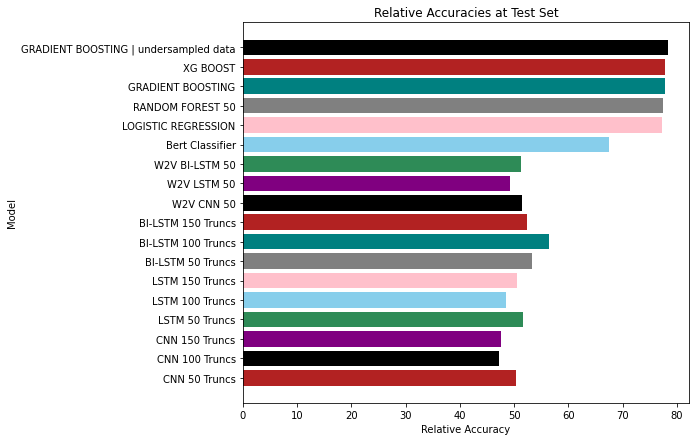

In [103]:
# Horizontal Bar plot
import numpy as np
import matplotlib.pyplot as plt

models=['CNN 50 Truncs','CNN 100 Truncs','CNN 150 Truncs',
        'LSTM 50 Truncs','LSTM 100 Truncs','LSTM 150 Truncs',
        'BI-LSTM 50 Truncs','BI-LSTM 100 Truncs','BI-LSTM 150 Truncs',
        'W2V CNN 50','W2V LSTM 50','W2V BI-LSTM 50',
        'Bert Classifier',
        'LOGISTIC REGRESSION','RANDOM FOREST 50','GRADIENT BOOSTING','XG BOOST','GRADIENT BOOSTING | undersampled data']

accuracies=np.asarray([50.3,47.2,47.5,51.6,48.5,50.5,53.3,56.5,52.4,51.4,49.2,51.2,67.4,77.3,77.5,77.8,77.8,78.3])
plt.figure(figsize=(8,7))
plt.barh(models,accuracies,color=['firebrick', 'black',
                    'purple', 'seagreen', 'skyblue','pink','gray','teal'])
plt.xlabel("Relative Accuracy")
plt.ylabel('Model')
plt.title('Relative Accuracies at Test Set')
plt.show()